In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [14]:
def f(x,a,b):
    """
    Linear function to fit.
    """
    return a*x+b

In [2]:
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = 10,7
plt.rcParams["figure.facecolor"] = "white"

In [3]:
df = pd.read_csv("../data/convergence_sigma_long.csv")

In [30]:
# creating unique ids for each community appending city id and community number
df["mgn_id"] = df["city"] + "_" + df["s_mgn"].map(str)
df["ms_id"] = df["city"] + "_" + df["s_ms"].map(str)

In [51]:
def get_coeff(l):
    """
    Given a list of values, and supposing that they are given for subsequent years,
    fit linear function on values and return slope and slope error.
    """
    p,pcov = curve_fit(f,range(len(l)),l)
    return p[0],np.sqrt(pcov[0,0])

In [32]:
# three different spatial aggregations
pairs = [
    ("county_id","cv_income_county"),
    ("mgn_id", "cv_income_mgn"),
    ("ms_id", "cv_income_ms")
]

In [33]:
results = {}

for level,cv_col in pairs:
    # calculate slope for all units and store result in a dict
    results[level] = df\
        .groupby([level,"year"])\
        [[cv_col]]\
        .first()\
        .dropna()\
        .reset_index()\
        .groupby([level])\
        [cv_col]\
        .agg(lambda x: list(x))\
        .map(lambda l: get_coeff(l)[0])\
        .to_dict()

Text(0, 0.5, 'PDF of slopes')

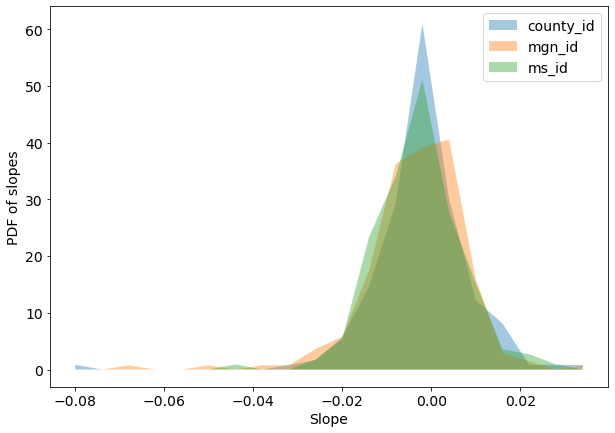

In [50]:
# plot distributions of slopes
plt.figure()
for level in results:
    y,x = np.histogram([v for k,v in results[level].items()],range=(-0.08,0.04),bins=20,density=True)
    plt.fill_between(x[:-1],y,label=level,lw=2,alpha=0.4)
plt.legend()
plt.xlabel("Slope")
plt.ylabel("PDF of slopes")